In [1]:
!pip install opencv-python scikit-learn numpy scikit-image


In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

For example, here we download and display a PNG image of the Colab logo:

In [3]:
!pip install mediapipe opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


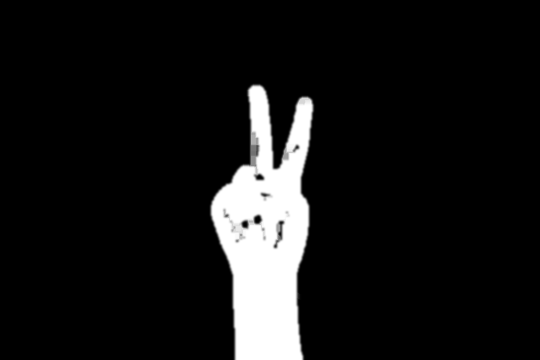

Defect 0: Angle = 135.00 degrees
Defect 1: Angle = 116.57 degrees
Defect 2: Angle = 135.00 degrees
Defect 3: Angle = 131.17 degrees
Defect 4: Angle = 135.00 degrees
Defect 5: Angle = 160.93 degrees
Defect 6: Angle = 161.34 degrees
Defect 7: Angle = 160.45 degrees
Defect 8: Angle = 135.00 degrees
Defect 9: Angle = 135.00 degrees
Defect 10: Angle = 34.74 degrees
Detected Gesture: Peace Sign with Defects: 1


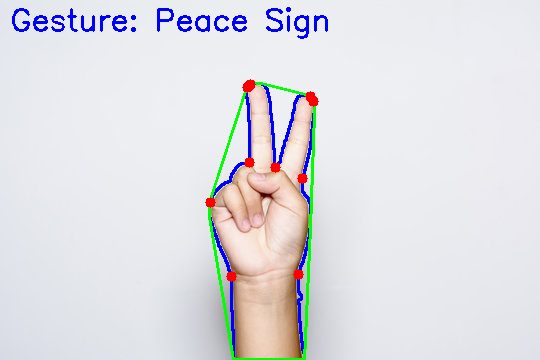

In [4]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the image
image = cv2.imread('/content/Peace sign.jpg')

# Check if the image was loaded successfully
if image is None:
    raise FileNotFoundError("Image not found. Please check the file path.")

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds of the skin color in HSV
lower_skin = np.array([0, 20, 70], dtype=np.uint8)
upper_skin = np.array([20, 255, 255], dtype=np.uint8)

# Apply mask to extract skin color
mask = cv2.inRange(hsv, lower_skin, upper_skin)

# Apply Gaussian blur and morphological operations
mask = cv2.GaussianBlur(mask, (5, 5), 0)
mask = cv2.erode(mask, None, iterations=2)
mask = cv2.dilate(mask, None, iterations=2)

# Display the mask for debugging
cv2_imshow(mask)

# Function to detect and classify gestures
def recognize_gesture(thresholded_image, frame):
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get the largest contour, assumed to be the hand
        largest_contour = max(contours, key=cv2.contourArea)
        contour_area = cv2.contourArea(largest_contour)

        # Only proceed if the contour area is above a threshold
        if contour_area > 1000:
            # Draw largest contour and convex hull
            cv2.drawContours(frame, [largest_contour], -1, (255, 0, 0), 2)  # Draw contour in blue
            hull = cv2.convexHull(largest_contour, returnPoints=False)
            cv2.drawContours(frame, [cv2.convexHull(largest_contour)], -1, (0, 255, 0), 2)  # Hull in green

            # Find defects in the convex hull
            defects = cv2.convexityDefects(largest_contour, hull)

            # Initialize gesture name and defect count
            gesture_name = "Unknown Gesture"
            num_defects = 0

            if defects is not None:
                for i in range(defects.shape[0]):
                    s, e, f, d = defects[i, 0]
                    start = tuple(largest_contour[s][0])
                    end = tuple(largest_contour[e][0])
                    far = tuple(largest_contour[f][0])

                    # Draw defect points in red
                    cv2.circle(frame, far, 5, (0, 0, 255), -1)

                    # Calculate angle to determine if it's a valid defect
                    a = np.linalg.norm(np.array(end) - np.array(start))
                    b = np.linalg.norm(np.array(far) - np.array(start))
                    c = np.linalg.norm(np.array(end) - np.array(far))
                    angle = np.arccos((b**2 + c**2 - a**2) / (2 * b * c))

                    # Print out angle for each defect for better understanding
                    print(f"Defect {i}: Angle = {np.degrees(angle):.2f} degrees")

                    # Adjust angle threshold to capture more or fewer defects
                    if angle < 100 * (np.pi / 180):  # Increasing angle threshold to 100 degrees
                        num_defects += 1

            # Gesture recognition based on defect count
            if num_defects == 0:
                gesture_name = "Fist"
            elif num_defects == 1:
                gesture_name = "Peace Sign"
            elif num_defects == 2:
                gesture_name = "Thumbs Up"
            elif num_defects >= 3:
                gesture_name = "Thumbs Down"

            # Display gesture name on the frame
            cv2.putText(frame, f"Gesture: {gesture_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            print(f"Detected Gesture: {gesture_name} with Defects: {num_defects}")

# Run the detection and gesture recognition function
recognize_gesture(mask, image)

# Display the processed image with detected gesture
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()
